In [195]:
# 两阶段预测销量（先用prophet捕捉节日特征，再用XGBoost预测，最后用SHAP解释 #
# prophet可以显示预测的残差，可以看到现在对

import pandas as pd
import chinese_calendar as calendar 
import datetime
### STEP1：读取数据 ###

# 超参数
COLS_PREDICT = '60000305_amount'
COLS_PREDICT_CNT = '60000305_order_cnt'
COLS_PRICE = '60000305_price'
COLS_PRICE_OTHER = '60000305_price_other'
COLS_CAR_FLOW = '站前车流量（汽油）'
COLS_CAR_RATE = '进站率（汽油）'
COLS_CAR_IN = '进站加油车量（汽油）'
COLS_DROP = ['date', 'amount', COLS_PREDICT, COLS_PREDICT_CNT, COLS_PRICE_OTHER]
COLS_ALL = ['date', 'amount', COLS_CAR_FLOW,
            'text_day', 'text_night', 'high', 'low', 
            'wc_day', 'wd_day', 'wc_night', 'wd_night', 
            COLS_PRICE, COLS_PRICE_OTHER, COLS_PREDICT, COLS_PREDICT_CNT, COLS_CAR_RATE, COLS_CAR_IN
            ]

# 读取excel文件并获取指定列
df = pd.read_csv('../Data/竞争站分析-竞争站-单站-32801309.csv', usecols=COLS_ALL, encoding='GBK')
print(df.head())

       date     amount  进站加油车量（汽油）  进站率（汽油）  站前车流量（汽油） text_day text_night  \
0  2023/1/1  105172.09         161     4.50       3576       多云         多云   
1  2023/1/2  212527.77         212     5.73       3704       多云         多云   
2  2023/1/3  166642.07         196     4.78       4099        晴          晴   
3  2023/1/4  110388.43         160     4.02       3980        晴         多云   
4  2023/1/5  307893.96         183     4.31       4246       多云         多云   

   high  low wc_day wd_day wc_night wd_night  60000305_price  \
0     9    3    <3级    东北风      <3级       北风            7.55   
1     9   -1    <3级     东风      <3级      东北风            7.55   
2    10   -2    <3级    东北风      <3级      东南风            7.55   
3    11   -1    <3级     南风      <3级      东南风            7.75   
4    13    2    <3级    东南风      <3级       西风            7.75   

  60000305_price_other  60000305_order_cnt  60000305_amount  
0   [5.49, 7.05, 7.55]                 132         27349.85  
1   [5.49, 7.05, 7.55]

11:02:06 - cmdstanpy - INFO - Chain [1] start processing
11:02:06 - cmdstanpy - INFO - Chain [1] done processing


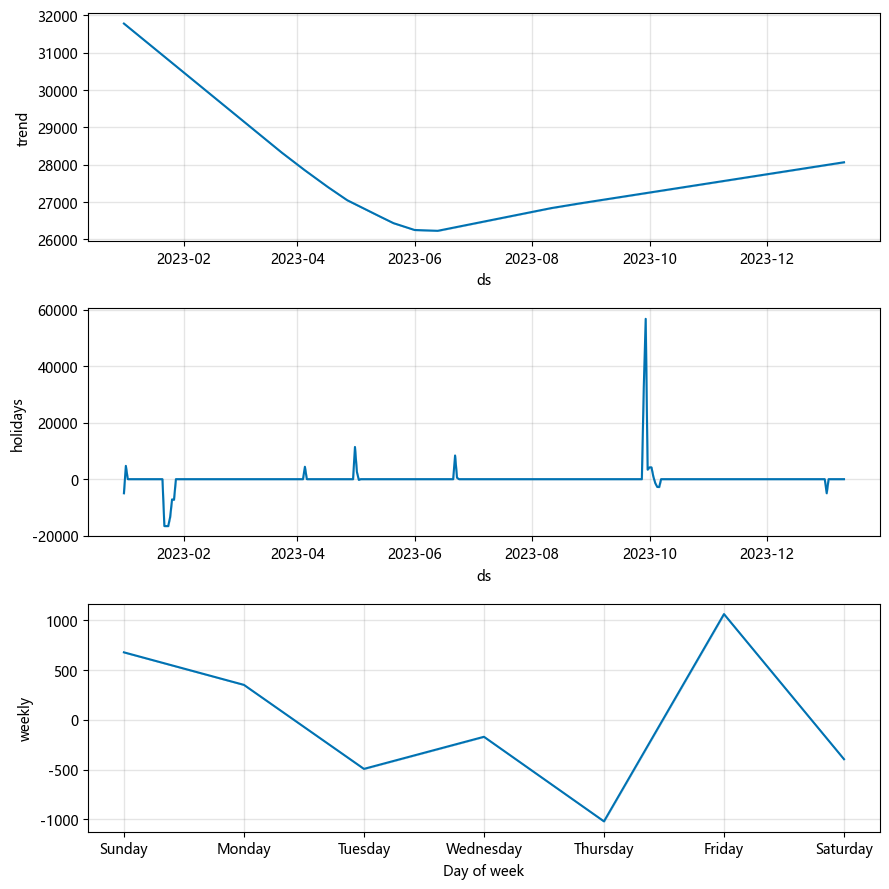

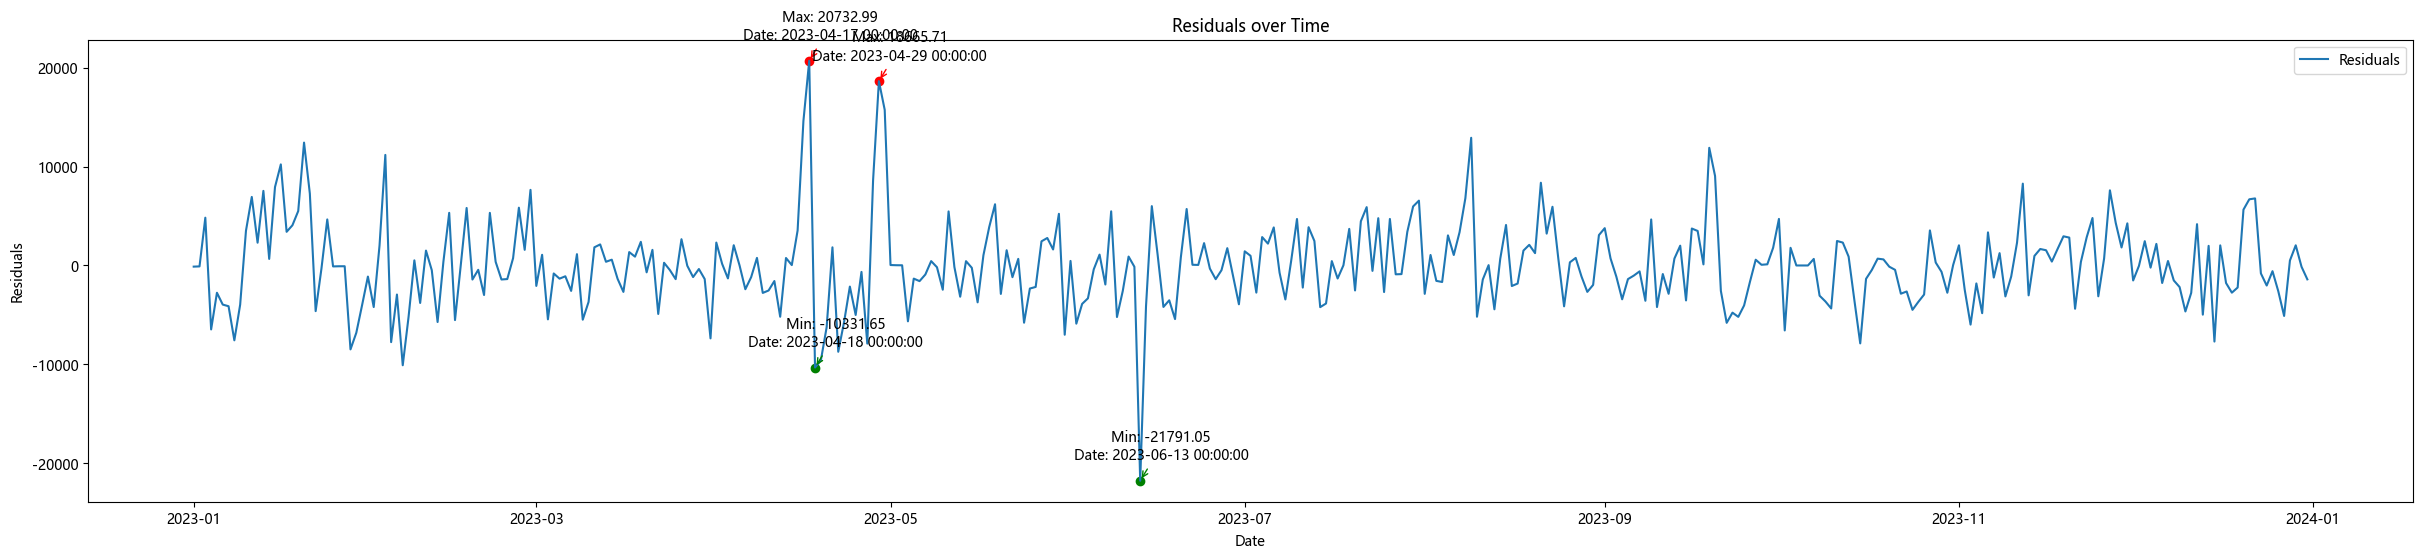

In [196]:
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
import matplotlib.pyplot as plt


# 第一步：构建输入DataFrame 
df_prophet = df[['date', COLS_PREDICT]].copy()      # 第一列必须被命名为“ds”并包含日期信息； 第二列必须被命名为“y”并包含观测结果。
df_prophet.rename(columns={'date':'ds', COLS_PREDICT:'y'}, inplace=True) 

# 第二步：训练模型
#model.add_country_holidays(country_name='CN')
holidays_df = make_holidays_df(year_list=[2023,2024], country='CN')
holidays_df.loc[holidays_df['holiday'] == 'Mid-Autumn Festival', 'lower_window'] = -1
holidays_df.loc[holidays_df['holiday'] == 'Mid-Autumn Festival', 'upper_window'] = 0
holidays_df.loc[holidays_df['holiday'] == 'National Day', 'lower_window'] = -1
holidays_df.loc[holidays_df['holiday'] == 'National Day', 'upper_window'] = 0
holidays_df = holidays_df.sort_values(by='ds')
model = Prophet(changepoint_range=0.8, 
                changepoint_prior_scale=0.1,
                holidays_prior_scale=1.0,
                holidays=holidays_df)
# print(holidays_df)
model.fit(df_prophet)

# 第三步：进行预测
future = model.make_future_dataframe(10)  # 例如，预测未来365天
forecast = model.predict(future)

# 第四步：可视化节假日、趋势、周周期性的影响
from prophet.plot import plot_components
fig = plot_components(model, forecast)

# 第四步（可选）：计算残差,绘制残差图
forecast['residuals'] = df_prophet['y'] - forecast['yhat']
plt.figure(figsize=(30, 6))
plt.plot(forecast['ds'], forecast['residuals'], label='Residuals')

# 找到残差最大的三个值和最小的三个值
top3_max_indices = forecast['residuals'].nlargest(2).index
top3_min_indices = forecast['residuals'].nsmallest(2).index

# 定义一个函数来标记极值点并添加注释
def annotate_extreme_values(indices, color, title):
    for idx in indices:
        date = forecast.at[idx, 'ds']
        residual = forecast.at[idx, 'residuals']
        plt.scatter(date, residual, color=color)
        plt.annotate(f'{title}: {residual:.2f}\nDate: {date}',
                     xy=(date, residual),
                     xytext=(15, 15),
                     textcoords='offset points',
                     ha='center', arrowprops=dict(arrowstyle="->", color=color))

# 标记最大/最小值点并添加注释
annotate_extreme_values(top3_max_indices, 'red', 'Max')
annotate_extreme_values(top3_min_indices, 'green', 'Min')

# 绘图
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals over Time')
plt.legend()
plt.show()

In [197]:
### 加入prophet的特征 ###
# 将 Prophet 的预测后形成的四列新特征，合并到原始 DataFrame
components_to_use = ['trend', 'holidays', 'weekly']
# components_to_use = ['trend', 'holidays', 'weekly', 'yhat']
existing_components = [col for col in components_to_use if col in forecast.columns]
forecast_aligned = forecast.iloc[:len(df)][existing_components]     #虽然prophet预测了额外的日期，但我们不需要，在这里舍去。我们用的是它的分解趋势的能力，并作为特征。
print(f"原始的df.shape：{df.shape}")
print(f"forecast.shape：{forecast.shape}")

# 合并特征
df = pd.concat([df, forecast_aligned[existing_components]], axis=1)
print(f"合并后df.shape：{df.shape}")

原始的df.shape：(365, 17)
forecast.shape：(375, 95)
合并后df.shape：(365, 20)


In [198]:
### STEP2：数据处理 ###
import chinese_calendar as  calendar
# 处理日期特征，引入若干个日期相关特征
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['amount_lag1'] = df['amount'].shift(1)   #创建滞后特征
df['amount_rolling_mean'] = df['amount'].shift(1).rolling(window=13).mean()   #过去n天的移动平均，滑动窗口。你需要shift一位以免使用当前天数的amount来预测，这样属于透题。


# 处理节假日,引入两个新特征
def check_holiday_workday(date):
    on_holiday, holiday_name = calendar.get_holiday_detail(date)
    return on_holiday, holiday_name
df[['on_holiday', 'holiday_name']] = df['date'].apply(lambda x: check_holiday_workday(x)).apply(pd.Series)
#print(df.head(30))
#print(df.iloc[260:281]) 

# 处理竞争站点信息
import CompetingStationPrice_Utils as PriceUtils

# 新列：竞争站点价格
df[COLS_PRICE_OTHER] = df[COLS_PRICE_OTHER].apply(PriceUtils.get_second_lowest_price)

# 新列：当前油品的价格变化（相较前一日）
df['价格变化'] = df[COLS_PRICE] - df[COLS_PRICE].shift(1)
df['价格变化'] = df['价格变化'].fillna(0)

# 新列：当前油品的竞争价格变化
# df['竞争站价格变化'] = df[COLS_PRICE_OTHER] - df[COLS_PRICE_OTHER].shift(1)
# df['竞争站价格变化'] = df['竞争站价格变化'].fillna(0)

# 新列：当前油品的差价
df['价格差'] = df[COLS_PRICE] - df[COLS_PRICE_OTHER]        # 我们比对方贵为正数， 便宜为负数

# 新列：当前油品的价差变化
# df['价格差变化'] = df['价格差'] - df['价格差'].shift(1)
# df['价格差变化'] = df['价格差变化'].fillna(0)

# 处理类别特征
categorical_features_name = ['text_day','text_night','wc_day','wd_day','wc_night','wd_night','holiday_name']  
for col in categorical_features_name:
    df[col] = df[col].astype('category')

#print(df.info())
# pd.set_option('display.max_columns', None)
print(df.head())

        date     amount  进站加油车量（汽油）  进站率（汽油）  站前车流量（汽油） text_day text_night  \
0 2023-01-01  105172.09         161     4.50       3576       多云         多云   
1 2023-01-02  212527.77         212     5.73       3704       多云         多云   
2 2023-01-03  166642.07         196     4.78       4099        晴          晴   
3 2023-01-04  110388.43         160     4.02       3980        晴         多云   
4 2023-01-05  307893.96         183     4.31       4246       多云         多云   

   high  low wc_day  ...  year month day  weekday  amount_lag1  \
0     9    3    <3级  ...  2023     1   1        6          NaN   
1     9   -1    <3级  ...  2023     1   2        0    105172.09   
2    10   -2    <3级  ...  2023     1   3        1    212527.77   
3    11   -1    <3级  ...  2023     1   4        2    166642.07   
4    13    2    <3级  ...  2023     1   5        3    110388.43   

   amount_rolling_mean  on_holiday    holiday_name  价格变化  价格差  
0                  NaN        True  New Year's Day   0.0  0.5  


KeyError: 'residuals'

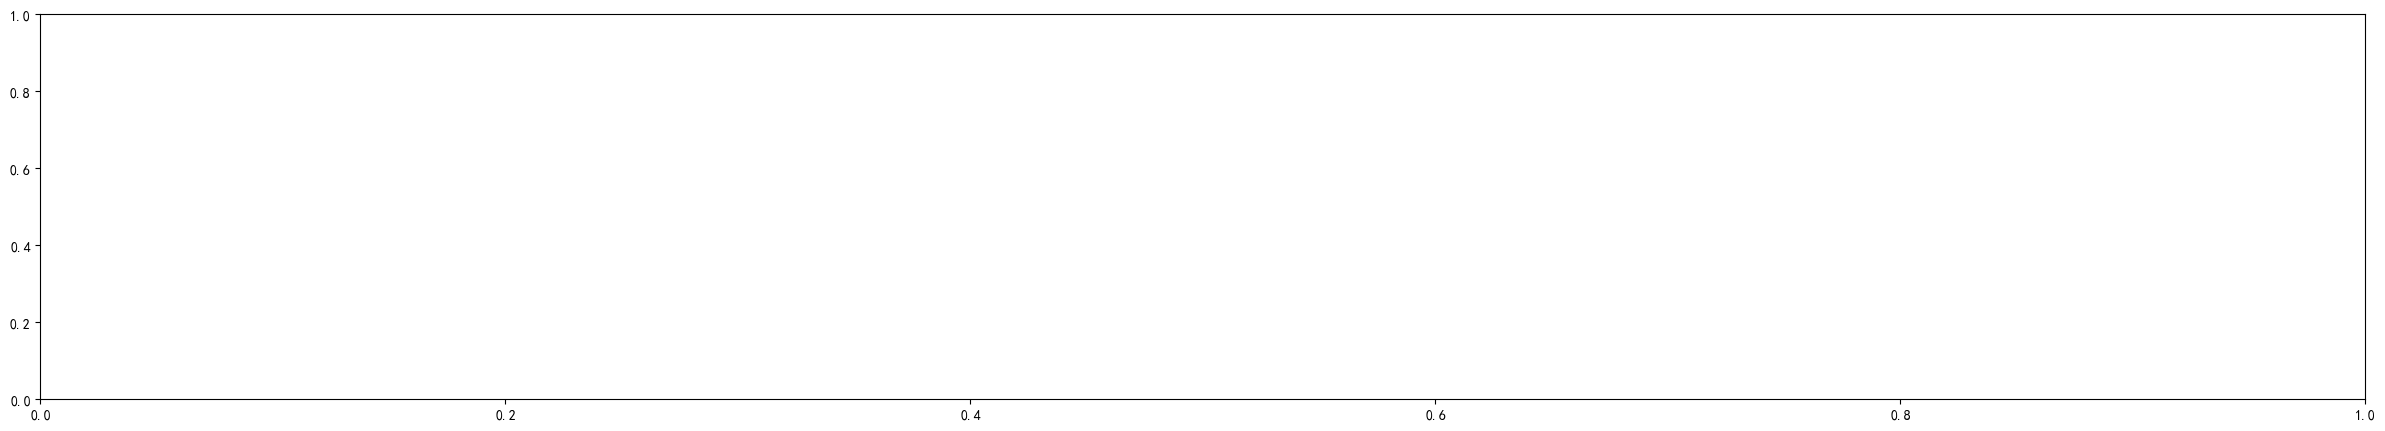

In [199]:
# 使用折线图进行数据描述
import matplotlib.pyplot as plt

# 定义数据列
COLS_X ='date'
COLS_Y1 =  COLS_CAR_FLOW
COLS_Y2 = 'on_holiday'

# 设置字体，确保能正确显示汉字
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体

# 创建一个图表和轴对象
fig, ax1 = plt.subplots(figsize=(30,5))

# 绘制第一条曲线
ax1.plot(df[COLS_X].head(365), df[COLS_Y1].head(365), 'r-', label=COLS_Y1)
ax1.set_xlabel(COLS_X)
ax1.set_ylabel(COLS_Y1, color='r')

# 利用twinx()创建第二个Y轴
ax2 = ax1.twinx()

# 绘制第二条曲线
ax2.plot(df[COLS_X].head(365), df[COLS_Y2].head(365), 'b-', label=COLS_Y2)
ax2.set_ylabel(COLS_Y2, color='b')

# 显示图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 显示图表
plt.show()

In [ ]:
### STEP3：XGBoost训练 ###
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


# 指定自变量和因变量
X = df.drop(columns=COLS_DROP, axis=1)
y = df[COLS_PREDICT]
print(f"训练集特征数: {X.shape}")

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 归一化，用独热编码分类变量，用MinMax归一化数值变量
scaler = MinMaxScaler()     #scaler = StandardScaler()
numerical_cols = X_train.select_dtypes(include=['int32', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
encoder = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_cols),
        ('cat', encoder, categorical_cols)
    ])
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
#print(X_train_preprocessed)

# 获取独热编码后的列名
categorical_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
numerical_names = numerical_cols
# 合并所有列名
all_names = numerical_names.tolist() + categorical_names
# 将预处理后的数据转换为数组形式，并确保形状正确
if X_train_preprocessed.shape[1]!= len(all_names):
    raise ValueError("Shape mismatch between data and column names.")
# 创建 DataFrame
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_names)
# print(X_train_preprocessed_df.head())

# 检查 y_train 中是否有 NaN 值
print(y_train.isnull().any())
y_train = y_train.fillna(y_train.mean())

# 使用xgb的XGBRegressor进行预测，指定目标为均方误差
model = xgb.XGBRegressor(objective='reg:squarederror', enable_categorical=True)
model.fit(X_train_preprocessed, y_train)

# 预测
y_pred = model.predict(X_test_preprocessed)


In [ ]:
### STEP4：XGBoost评估 ###
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

# 计算均方根误差（RMSE）
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print(f'{COLS_PREDICT}的均方开方误差(RMSE): {rmse:.2f}')
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'{COLS_PREDICT}的平均绝对百分比误差 (MAPE): {mape:.2f}')

In [ ]:
### STEP5：特征选择并重新评估 ###
import numpy as np
from sklearn.feature_selection import SelectFromModel
# 获取特征重要性得分
importance = model.feature_importances_

# 将特征重要性得分排序（从高到低）
indices = np.argsort(importance)[::-1]

# 打印特征和它们的重要性得分
# print("Feature ranking:")
# for f, i in enumerate(indices):
#     print("%d. Feature %d (%f)" % (f + 1, i, importance[i]))

# 使用SelectFromModel进行特征选择
selector = SelectFromModel(model, threshold='mean', prefit=True)
X_train_selected = selector.transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)

# 训练新模型
model_selected = xgb.XGBRegressor(objective='reg:squarederror', enable_categorical=True)
model_selected.fit(X_train_selected, y_train)
y_pred_selected = model_selected.predict(X_test_selected)

# 计算均方根误差（RMSE）
print(y_test.shape)
print(y_pred_selected.shape)
mse = mean_squared_error(y_test, y_pred_selected)
rmse = sqrt(mse)
print(f'{COLS_PREDICT}的均方开方误差(RMSE): {rmse:.2f}')
mape = mean_absolute_percentage_error(y_test, y_pred_selected)
print(f'{COLS_PREDICT}的平均绝对百分比误差 (MAPE): {mape:.2f}')


In [ ]:
# 获取特征重要性得分
importance = model_selected.feature_importances_

# 将特征重要性得分排序（从高到低）
indices = np.argsort(importance)[::-1]

# 打印特征和它们的重要性得分
print("Feature ranking:")
for f, i in enumerate(indices):
    print("%d. Feature %d (%f)" % (f + 1, i, importance[i]))

In [ ]:
import shap
shap.initjs()
# STEP 1：创建 TreeExplainer 解释器（因为这里要解释XGB的model）
explainer = shap.TreeExplainer(model)

# STEP 2：计算 SHAP 值
shap_values = explainer.shap_values(X_train_preprocessed)

# STEP 3：转换为explanation对象，再用shap.lots.bar显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X_train_preprocessed,feature_names=X_train_preprocessed_df.columns.tolist())
# shap.plots.bar(explanation[2], max_display=69)
shap.plots.waterfall(explanation[100], max_display=69)

# 可视化第一个样本的 SHAP 值（力图）
#shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_preprocessed[0,:])

# 可视化所有样本的特征重要性（汇总图）
# shap.summary_plot(shap_values, 
#                   X_train_preprocessed, 
#                   feature_names=X_train_preprocessed_df.columns.tolist(),
#                   max_display=30)


